### Always to run stuff

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [3]:
from video_pipeline.video_module import *

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


In [5]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

# test_dataset = Stack_dataset(jn(output_path, 'test'), jn(input_path, 'test'), frames_number,
#                              frames_interval)
# train_dataset = Stack_dataset(jn(output_path, 'train'), jn(input_path, 'train'), frames_number,
#                               frames_interval)

def get_elemenst_from_dataset(slice, key_id=10):
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [6]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)
import torch_real_sim_lib as trsl
new_sim = trsl.FiberSimulator(config)
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)


In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

### Клетка для запуска.

### End of always run stuff.
### Beginning of code.

Загрузка лога хорошего протыкивания

In [8]:
!wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" -O cert.crt -q
import os
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


try:
    import dotenv
    dotenv.load_dotenv()
except ImportError:
    pass

client = pymongo.MongoClient(
    host=os.environ['host'],
    port=27018,
    replicaSet='rs01',
    username=os.environ['username'],
    password=os.environ['password'],
    authSource=os.environ['database'],
    tls=True,
    tlsCAFile='cert.crt'
)
db = client[os.environ['database']]

In [9]:
from scipy.interpolate import interp1d

def interplating_parser(target_tenso_signal, subtracting_first=True):
    def log_pars_func(point_res_dict):
        '''Returns signal(target_tenso_signal) value gotten by interpolation'''
        x = np.array(point_res_dict['tenso_signal'])
        y = np.array(point_res_dict['final_power'])
        y = y[x != None]
        x = x[x != None]
        if subtracting_first:
            x = [t - x[0] for t in x]
        x = [float(t) for t in x]
        x = x + np.random.normal(0, 0.0001, len(x))     # чтобы не было совпадений по x
        interpolated_function = interp1d(x, y, kind='linear', fill_value='extrapolate')
        return 1 - interpolated_function(target_tenso_signal)/y[0]
    return log_pars_func
log_pars_func = interplating_parser(15)


In [11]:
# def log_pars_func(point_res_dict):
#     '''Returns max(absolute value) force'''
#     return np.abs(point_res_dict['final_power']).min()
    
def sensor_plotting(points_curves, log_parser_function, vis='hist2d', hist2d_kwargs={}):
    '''Plots 3d or heatmap visualization of spatial characteristics of sensor
    log_parser_function(dict_with_results_in_one_point) -> 1d value to visualize
    example:
    def log_pars_func(point_res_dict):
        """Returns max(absolute value) force"""
        return np.abs(point_res_dict['force_z']).max()
        
    '''
    X = []
    Y = []
    Z = []
    for point_res in points_curves:
        xy = point_res['relative_coordinate']
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(log_parser_function(point_res))
    
    if vis == "scatter":
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    #     ax.plot_surface(np.array(X).reshape(-1, 1)), np.array(Y).reshape(1, -1), np.array(Z).reshape())
        ax.scatter(np.array(X), np.array(Y), np.array(Z))
        # plt.hexbin(np.array(X), np.array(Y), np.array(Z), gridsize=(10, 2))
    elif vis == 'hist2d':
        xs = set(X)
        ys = set(Y)
        shape = (len(xs), len(ys))
        plt.hist2d(np.array(X), np.array(Y), weights=np.array(Z), bins=shape, **hist2d_kwargs)
        


In [12]:
# %matplotlib notebook
id = 727
%matplotlib inline
points_curves_1 = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
points_curves_1 = [point_res for point_res in points_curves_1 if point_res['relative_coordinate'][0] < 16.45]

KeyboardInterrupt: 

In [ ]:
# %matplotlib notebook
id = 728
%matplotlib inline
points_curves_2 = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']

In [ ]:
points_curves = points_curves_1 + points_curves_2

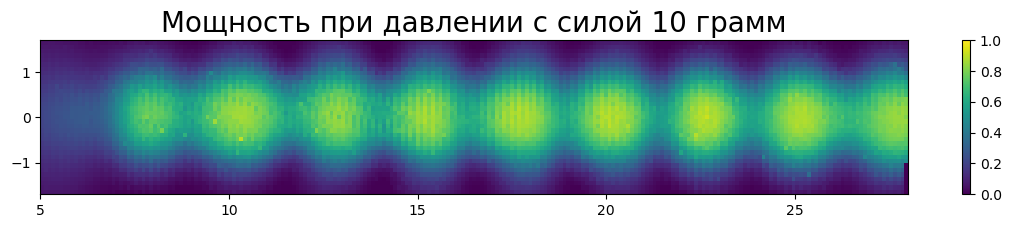

In [ ]:

tenso_target = 10
log_pars_func = interplating_parser(tenso_target, subtracting_first=True)

plt.figure(figsize=(14, 2))
# sensor_plotting(id, log_pars_func, shape=[21, 35],  )
sensor_plotting(points_curves, log_pars_func, hist2d_kwargs={"vmin": 0, "vmax": 1} )
plt.colorbar()
plt.title(f"Мощность при давлении с силой {tenso_target} грамм", fontsize=20);

#### Подбор правильного параметра силы гауссового блюра

In [ ]:
config['env']['sen_geometry']['n_angles'] = 1

In [ ]:
config['env']['sen_geometry']['distance'] = 0.1
config['env']['phys']['sigma']

0.8

In [ ]:
def gen_point_pres(x):
    point_pres = np.zeros((70, 55), dtype=np.float32)
    point_pres[x, 55//2] = 1 
    return point_pres
point_pres = gen_point_pres(35)

In [ ]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

Rot tensors


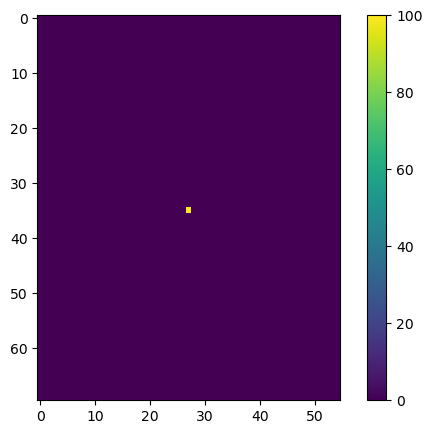

After blur


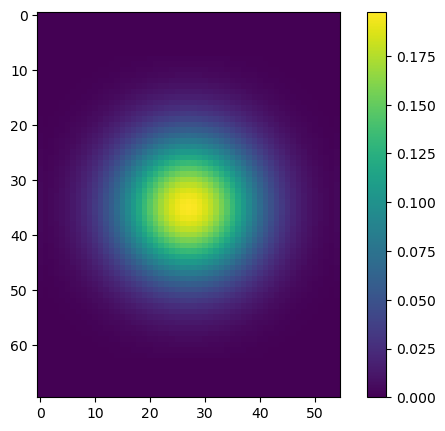

Loss in fiber


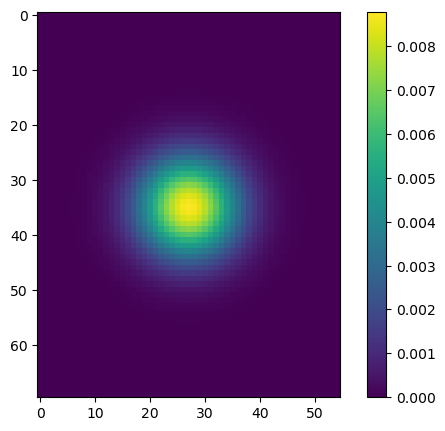

Loss sums


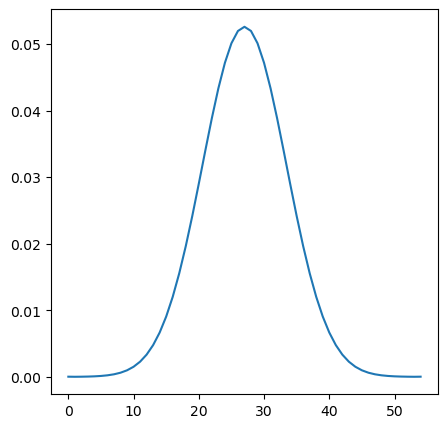

Signal


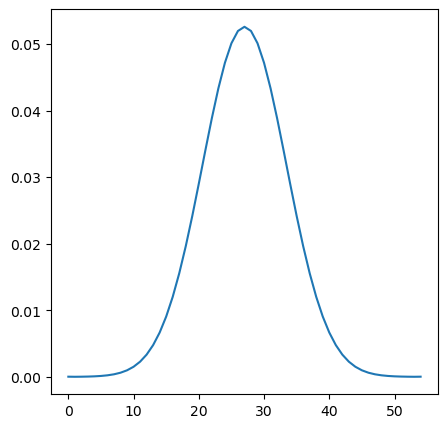

In [ ]:
sim.test = True
res = sim.fiber_real_sim(point_pres*100)
sim.test = False

ValueError: x and y must have same first dimension, but have shapes (35,) and torch.Size([55])

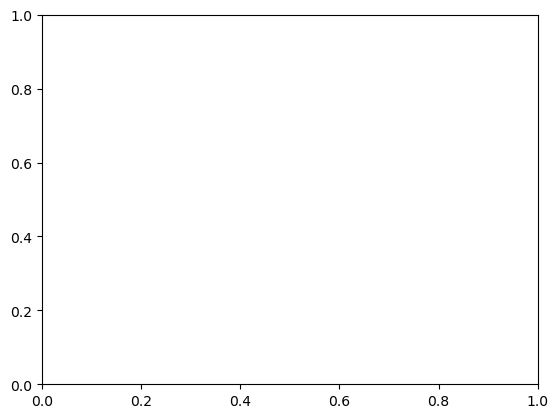

In [ ]:
amps = np.linspace(20, 900, 10)
for amplitude in amps:
    profile = sim.fiber_real_sim(point_pres*amplitude)[0][0]
    plt.plot(np.linspace(-1.7, 1.7, 35), profile)

### Экспериментальные профили гауссовы

In [ ]:
rel_x = 15.3
filtered_points = [t for t in points_curves if abs(t['relative_coordinate'][0]-rel_x)<0.05]
# for point_res in filtered_points:
#     print(point_res['relative_coordinate'])

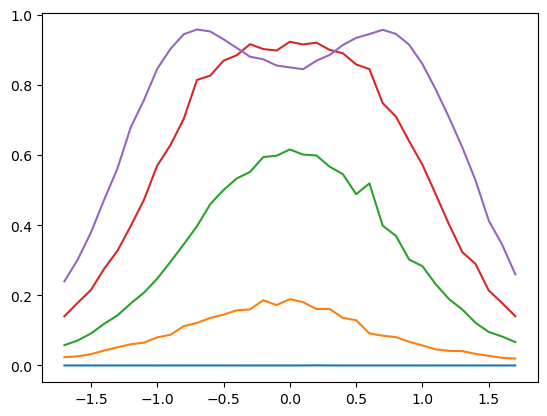

In [ ]:

tenso_target = 10
for tenso_target in np.linspace(0, 15, 5):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
    X = []
    signals = []
    for point_res in filtered_points:
        X.append(point_res['relative_coordinate'][1])
        signals.append(log_pars_func(point_res))
    plt.plot(X, signals)


до 12 грамм можно менять силу. При этом где-то до 380 нужно повышать амплитуду симулированного сигнала.

In [ ]:
config['env']['phys']['sigma'] = 1
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

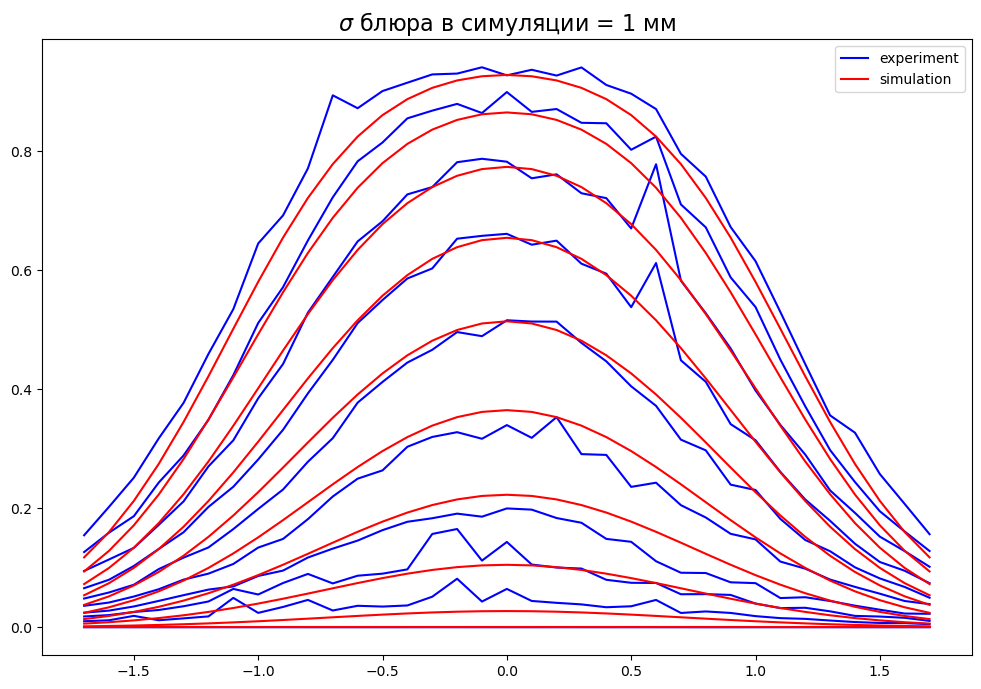

In [ ]:
N = 10
plt.figure(figsize=(12, 8))
for tenso_target, amplitude in zip(np.linspace(0, 12, N), np.linspace(0, 900, N)):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
    X = []
    signals = []
    for point_res in filtered_points:
        X.append(point_res['relative_coordinate'][1])
        signals.append(log_pars_func(point_res))
    plt.plot(X, signals, 'b')

    profile = sim.fiber_real_sim(point_pres*amplitude)[0][0]
    l = (len(profile) - 35)//2
    plt.plot(np.linspace(-1.7, 1.7, 35), profile[l:-l], 'r')
plt.legend(["simulation", "experiment"][::-1])
plt.title("$\sigma$ блюра в симуляции = 1 мм", fontsize=16)
# plt.savefig("sigma_find.jpg")
plt.show()

Таким образом ориентироваться лучше на сигму равную 0.9

### Сравниваю синусойды

#### Экспериментальная синусойда

In [ ]:
rel_y = 0
filtered_points = [t for t in points_curves if abs(t['relative_coordinate'][1]-rel_y)<0.05]

In [ ]:
N = 3

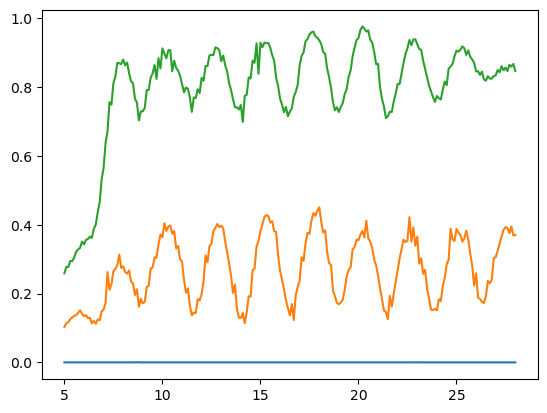

In [ ]:
for tenso_target in np.linspace(0, 12, N):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
    Y = []
    signals = []
    for point_res in filtered_points:
        Y.append(point_res['relative_coordinate'][0])
        signals.append(log_pars_func(point_res))
    plt.plot(Y, signals)

#### Симулированные

In [ ]:
config['env']['phys']['sigma'] = 0.9

In [ ]:
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)

In [ ]:
def gen_point_pres(x):
    d = 41
    point_pres = np.zeros((180, d), dtype=np.float32)
    point_pres[x, d//2] = 1 
    return point_pres
point_pres = gen_point_pres(35)

In [ ]:
indent = 30
# indent = 0
dataset_point_presses = np.zeros((point_pres.shape[0]-2*indent,) + point_pres.shape, dtype=np.float32)
for i in range(indent, point_pres.shape[0]-indent):
    dataset_point_presses[i-indent] = gen_point_pres(i)

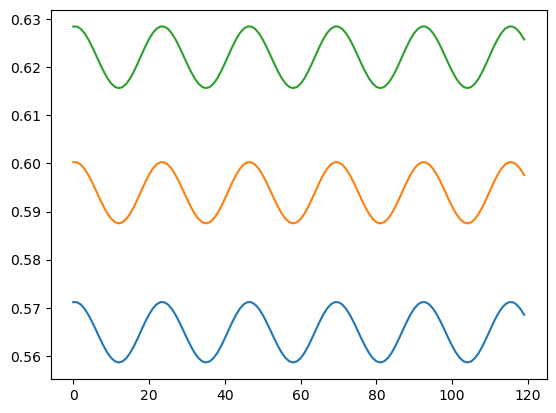

In [ ]:
# for amplitude in np.linspace(0, 450, N):
for amplitude in np.linspace(250, 270, N):
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    plt.plot(sinus)

In [ ]:
N = 10

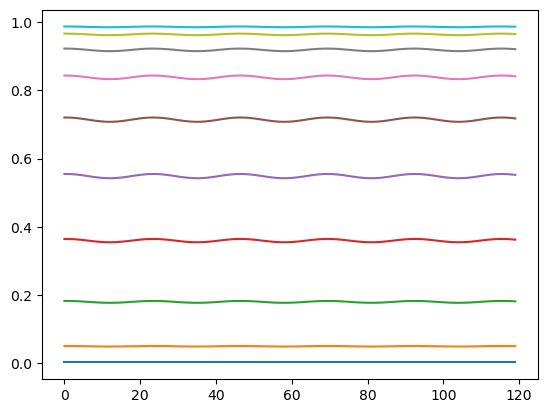

In [ ]:
for amplitude in np.linspace(0, 550, N):
# for amplitude in np.linspace(250, 270, N):
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    plt.plot(sinus)

Rot tensors


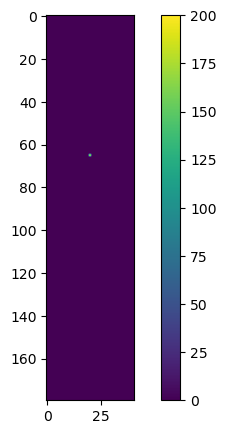

After blur


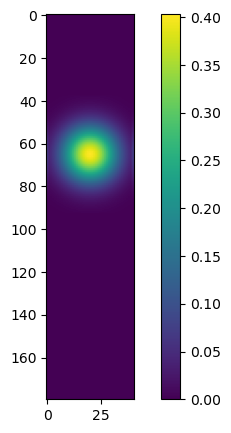

Loss sums


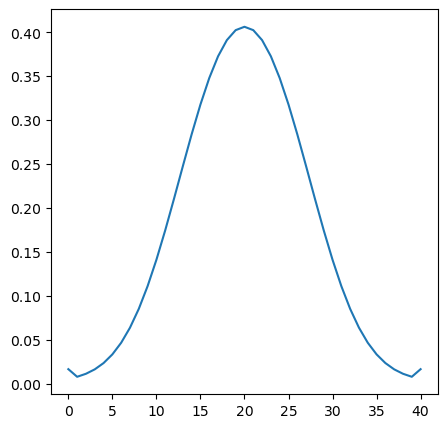

In [ ]:
simb.test=True
simb.fiber_real_sim(dataset_point_presses[35:36]*200)
simb.test=False

Дичь какая-то, но по-моему, гауссов блюр очень неудобно для меня работает. Нужно свой все таки реализовать. А пока использовать широкие карты для симуляции

#### Решаю проблемы с гауссовым блюром.

In [ ]:
from torchvision.transforms.functional import gaussian_blur
data = torch.zeros((1, 1, 35, 70*3))
blured_data = gaussian_blur(data, kernel_size=[581, 9], sigma=27)

RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (290, 290) at dimension 3 of input 4

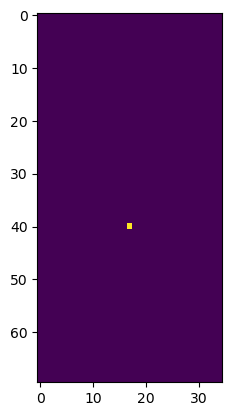

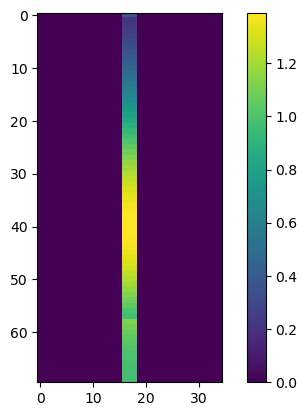

In [ ]:
kernel_shape = np.minimum([3, 100], simb.gaus_kernel_size)
kernel_shape = [t if t%2==1 else t-1 for t in kernel_shape]
data = torch.from_numpy(dataset_point_presses[35:36]*200)
plt.imshow(data[0])
plt.show()
blured = gaussian_blur(data, [3, 81], 20)
plt.imshow(blured[0])
plt.colorbar()

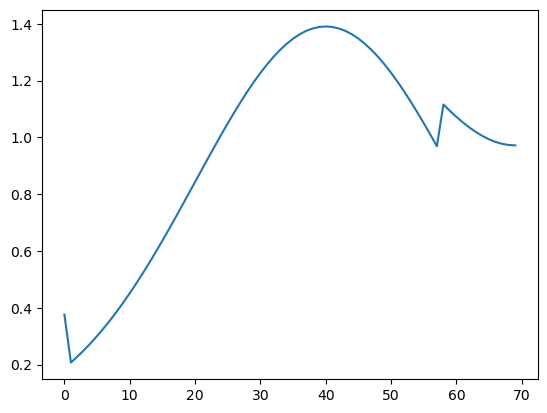

In [ ]:
plt.plot(blured[0, :, 17])

просто пытаюсь понять, как этот долбанный блюр работает

In [ ]:
test_img = torch.zeros((1, 1, 64))
test_img[0, 0, 32] = 1

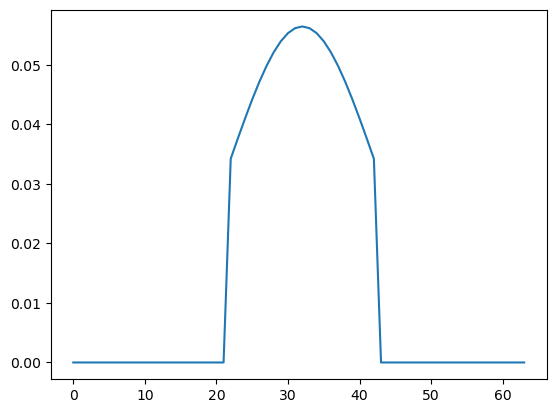

In [ ]:
blured = gaussian_blur(test_img, [21, 1], 10)
plt.plot(blured[0, 0])

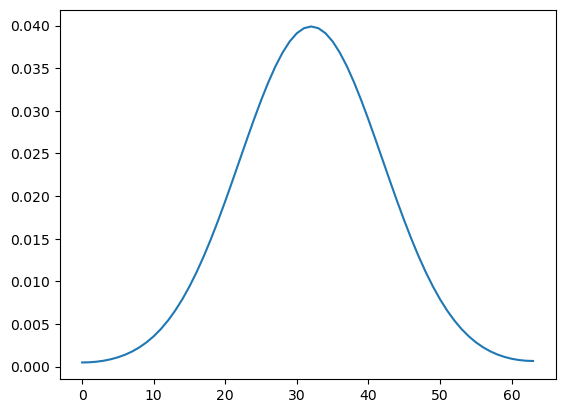

In [ ]:
blured = gaussian_blur(test_img, [121, 1], 10)
plt.plot(blured[0, 0])

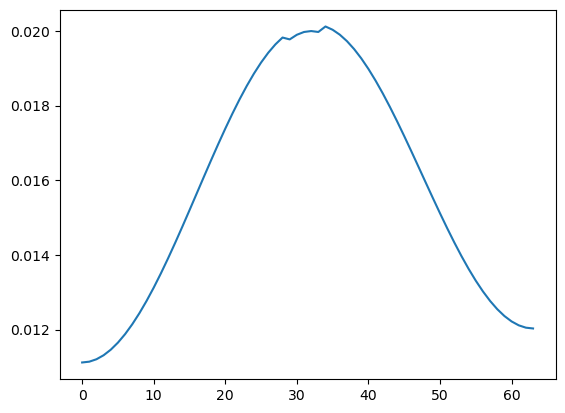

In [ ]:
blured = gaussian_blur(test_img, [121, 1], 20)
plt.plot(blured[0, 0])

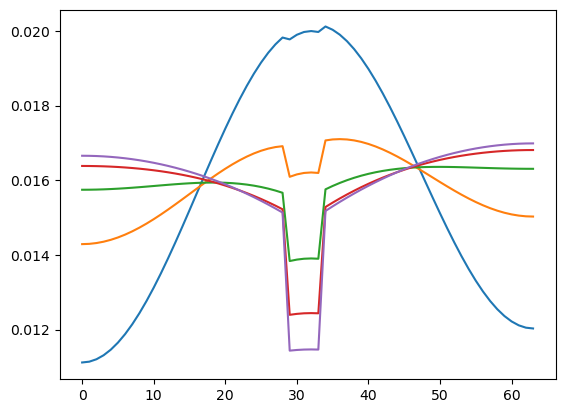

In [ ]:
for sigma in np.linspace(20, 40, 5):
    blured = gaussian_blur(test_img, [121, 1], sigma)
    plt.plot(blured[0, 0])

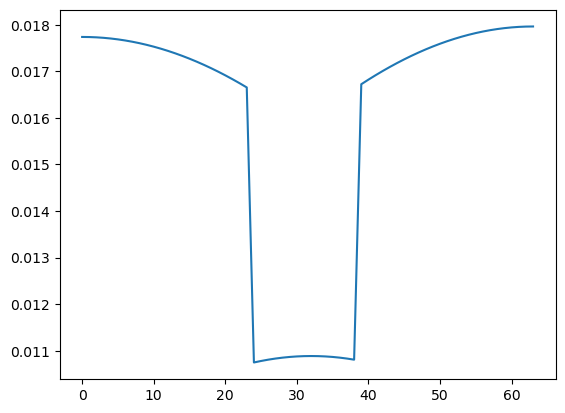

In [ ]:
blured = gaussian_blur(test_img, [111, 1], 50)
plt.plot(blured[0, 0])

In [ ]:
test_img = torch.zeros((1, 1, 64))
test_img[0, 0, 61] = 1

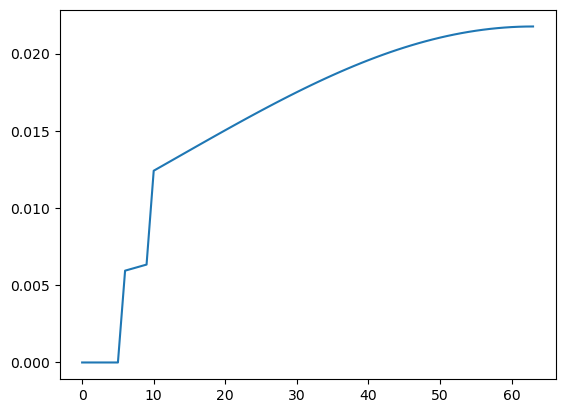

In [ ]:
blured = gaussian_blur(test_img, [111, 1], 50)
plt.plot(blured[0, 0])

### Пропускание в точке от силы.

In [ ]:
N = 30

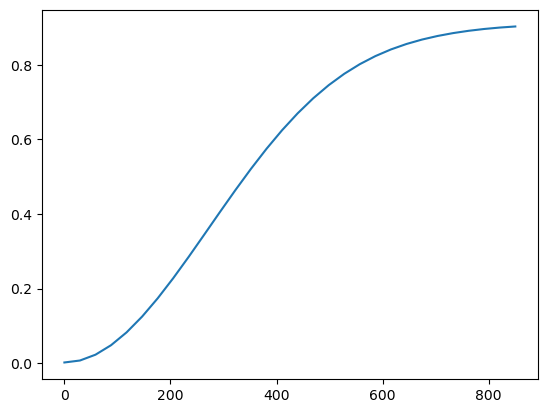

In [ ]:
# ampls = np.linspace(0, 450, N)
ampls = np.linspace(0, 850, N)
signal = []
for amplitude in ampls:
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    # plt.plot(sinus)
    signal.append(sinus[len(sinus)//2])
plt.plot(ampls, signal)

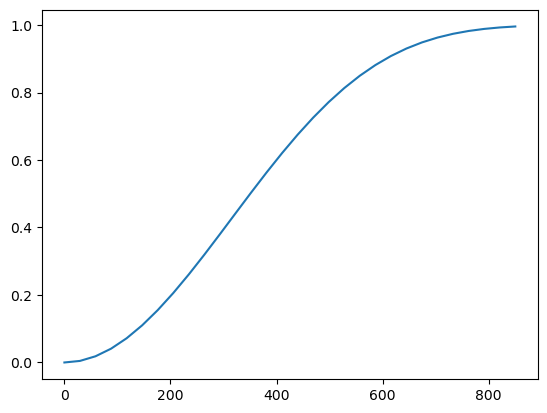

In [ ]:
# ampls = np.linspace(0, 450, N)
ampls = np.linspace(0, 850, N)
signal = []
for amplitude in ampls:
    result_numbers = sim.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    # plt.plot(sinus)
    signal.append(sinus[len(sinus)//2])
plt.plot(ampls, signal)

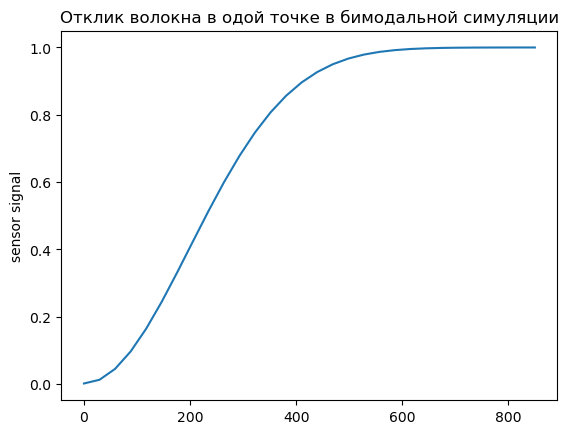

In [ ]:
plt.plot(ampls, signal)
plt.ylabel("sensor signal")
plt.title("Отклик волокна в одой точке в бимодальной симуляции")
# plt.savefig("onepoint_curve_bimodal.jpg")

In [ ]:
config['env']['bimodal']['intermode_matrix'] = [[0.5, 0], 
    [0.5, 0]]
simb = tbsl.FiberSimulator(config)


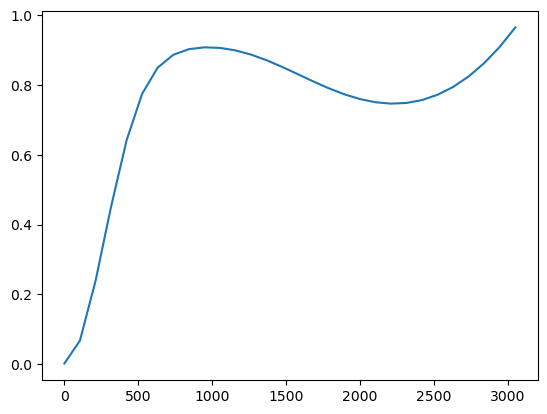

In [ ]:
ampls2 = np.linspace(0, 3050, N)
signal2 = []
for amplitude in ampls2:
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    # plt.plot(sinus)
    signal2.append(sinus[len(sinus)//2])
plt.plot(ampls2, signal2)

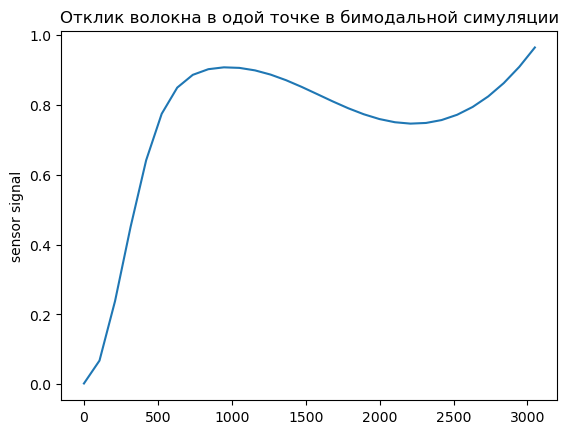

In [ ]:
plt.plot(ampls2, signal2)
plt.ylabel("sensor signal")
plt.title("Отклик волокна в одой точке в бимодальной симуляции")
# plt.savefig("onepoint_curve_bimodal2.jpg")

### Строю функцию для сравнения синусойд

In [ ]:
config['env']['bimodal']['borning_modes'] = [1, 0]
config['env']['bimodal']['impact_modes'] = [1, 1]

In [ ]:
def gen_point_pres(x):
    d = 41
    point_pres = np.zeros((209, d), dtype=np.float32)
    point_pres[x, d//2] = 1 
    return point_pres
point_pres = gen_point_pres(35)

In [ ]:
indent = 30
# indent = 0
dataset_point_presses = np.zeros((point_pres.shape[0]-2*indent,) + point_pres.shape, dtype=np.float32)
for i in range(indent, point_pres.shape[0]-indent):
    dataset_point_presses[i-indent] = gen_point_pres(i)

In [ ]:
def plot_sinuses(N, intermode_matrix):
    for tenso_target in np.linspace(0, 12, N):
        log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
        Y = []
        signals = []
        for point_res in filtered_points:
            Y.append(point_res['relative_coordinate'][0])
            signals.append(log_pars_func(point_res))
        Y = np.array(Y)
        signals = np.array(signals)
        filter = (Y>10) & (Y<25)
        
        signals = signals[filter]
        Y = Y[filter]
        Y -= Y.min()
        plt.plot(Y, signals, 'b')
    
    config['env']['bimodal']['intermode_matrix'] = intermode_matrix
    simb = tbsl.FiberSimulator(config)


    for amplitude in np.linspace(0, 450, N):
        result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
        sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
        X = np.linspace(0, (len(sinus)-1)*0.1, len(sinus))
        plt.plot(X, sinus, 'r')

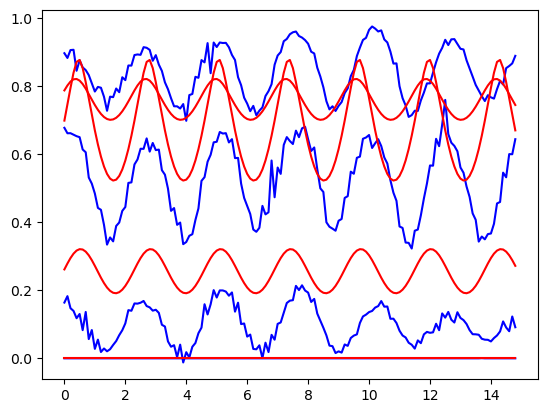

In [ ]:
plot_sinuses(4, [[1, 0], 
                 [0.6, 0]])

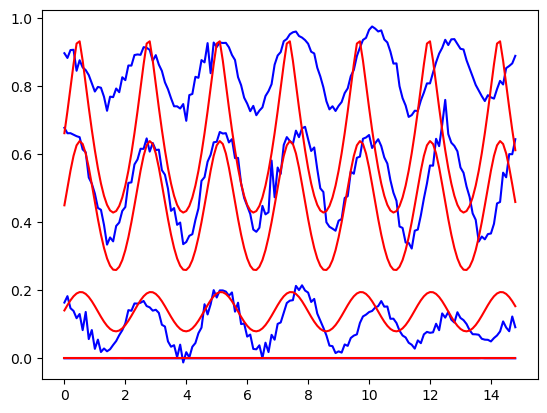

In [ ]:
plot_sinuses(4, [[0.5, 0], 
                 [0.5, 0]])

###  сверяю периоды синусойд

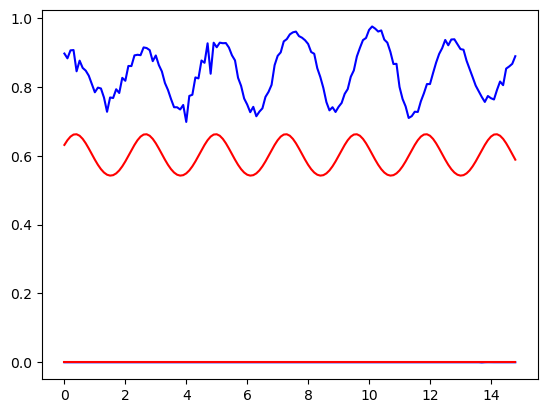

In [ ]:
for tenso_target in np.linspace(0, 12, 2):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
    Y = []
    signals = []
    for point_res in filtered_points:
        Y.append(point_res['relative_coordinate'][0])
        signals.append(log_pars_func(point_res))
    Y = np.array(Y)
    signals = np.array(signals)
    signals = signals[(Y>10) & (Y<25)]
    Y = Y[(Y>10) & (Y<25)]
    Y -= Y.min()
    plt.plot(Y, signals, 'b')

config['env']['bimodal']['intermode_matrix'] = [[1, 0], [1, 0]]
simb = tbsl.FiberSimulator(config)


for amplitude in np.linspace(0, 450, 2):
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude).numpy()
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    X = np.linspace(0, (len(sinus)-1)*0.1, len(sinus))
    plt.plot(X, sinus, 'r')

In [ ]:
def sinus_func(x, w, phi, A, C):
    return np.sin(x*w + phi)*A + C

from scipy.optimize import curve_fit
x, y = Y, signals
popt, pcov = curve_fit(sinus_func, np.array(x), np.array(y), p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(y)])
print(popt)
print("period is", np.pi*2/popt[0])
x, y = X, sinus
popt, pcov = curve_fit(sinus_func, np.array(x), np.array(y), p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(y)])
print(popt)
print("period is", np.pi*2/popt[0])



[ 2.48323001  4.6306224  -0.09834269  0.84383275]
period is 2.5302470085909676
[2.73181013 0.57045331 0.06017942 0.60045826]
period is 2.3000080551474564


In [ ]:
config['env']['bimodal']['period'] = 2.5

In [ ]:
def plot_sinuses(N, intermode_matrix):
    for tenso_target in np.linspace(0, 12, N):
        log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
        Y = []
        signals = []
        for point_res in filtered_points:
            Y.append(point_res['relative_coordinate'][0])
            signals.append(log_pars_func(point_res))
        Y = np.array(Y)
        signals = np.array(signals)
        a=0.7
        filter = (Y>10-a) & (Y<25-a)
        
        signals = signals[filter]
        Y = Y[filter]
        Y -= Y.min()
        plt.plot(Y, signals, 'b')
    config['env']['bimodal']['intermode_matrix'] = intermode_matrix
    simb = tbsl.FiberSimulator(config)


    for amplitude in np.linspace(0, 450, N):
        result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
        sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
        X = np.linspace(0, (len(sinus)-1)*0.1, len(sinus))
        plt.plot(X, sinus, 'r')

one
two


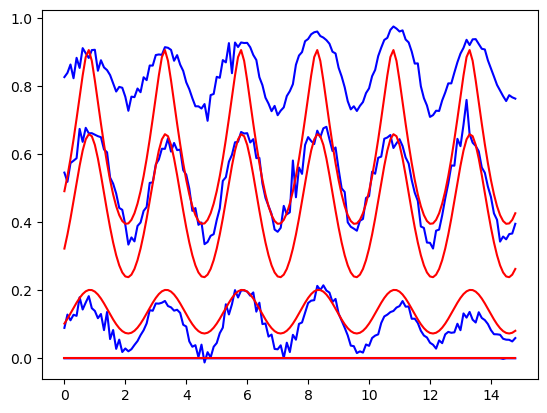

In [ ]:
plot_sinuses(4, [[0.5, 0], 
                 [0.5, 0]])

### Пишу автоподбор параметров

In [ ]:
def compare_sinuses1(N, C):
    ''' C is [mat[0, 0], mat[1, 0]'''
    intermode_matrix = [[C[0], 0], [C[1], 0]]
    
    config['env']['bimodal']['intermode_matrix'] = intermode_matrix
    simb = tbsl.FiberSimulator(config)
    res = []
    # for tenso_target in np.linspace(0, 12, N):
    # for amplitude in np.linspace(0, 450, N):
    for amplitude, tenso_target in zip(np.linspace(0, 450, N), np.linspace(0, 12, N)):
        log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
        Y = []
        signals = []
        for point_res in filtered_points:
            Y.append(point_res['relative_coordinate'][0])
            signals.append(log_pars_func(point_res))
        Y = np.array(Y)
        signals = np.array(signals)
        a=0.7
        filter = (Y>10-a) & (Y<25-a)
        
        signals = signals[filter]
        Y = Y[filter]
        Y -= Y.min()


        result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude).numpy()
        sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
        X = np.linspace(0, (len(sinus)-1)*0.1, len(sinus))
        
        # plt.plot(Y, signals, 'b')
        # plt.plot(X, sinus, 'r')
        res.append(np.sum(np.square(sinus-signals)))
    return res

In [ ]:
compare_sinuses1(4, [1, 0.5])

[4.0147940468867376e-07,
 3.6838369302569323,
 3.885016948675103,
 0.8657045818072597]

In [ ]:
from scipy.optimize import least_squares

In [ ]:
res_1 = least_squares(lambda C: compare_sinuses1(3, C), [1, 1])

In [ ]:
print(res_1.x)
print(res_1.message)
print(res_1.cost)


[1.00000033 1.00000028]
`xtol` termination condition is satisfied.
88.17954528425128


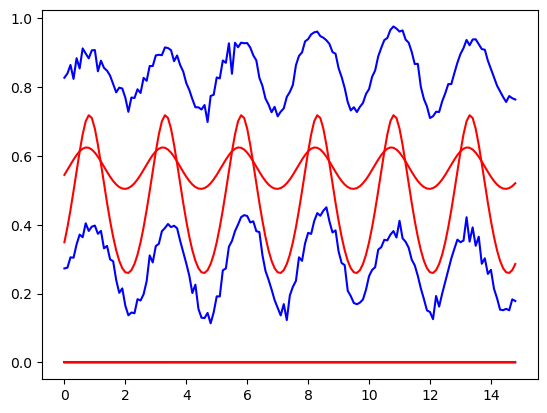

In [ ]:
plot_sinuses(3, [[1, 0], [1, 0]])

плохо. Надо еще руками поподбирать

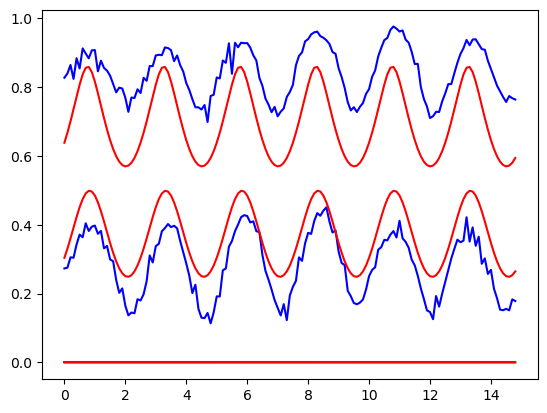

In [ ]:
plot_sinuses(3, [[0.7, 0], [0.5, 0]])

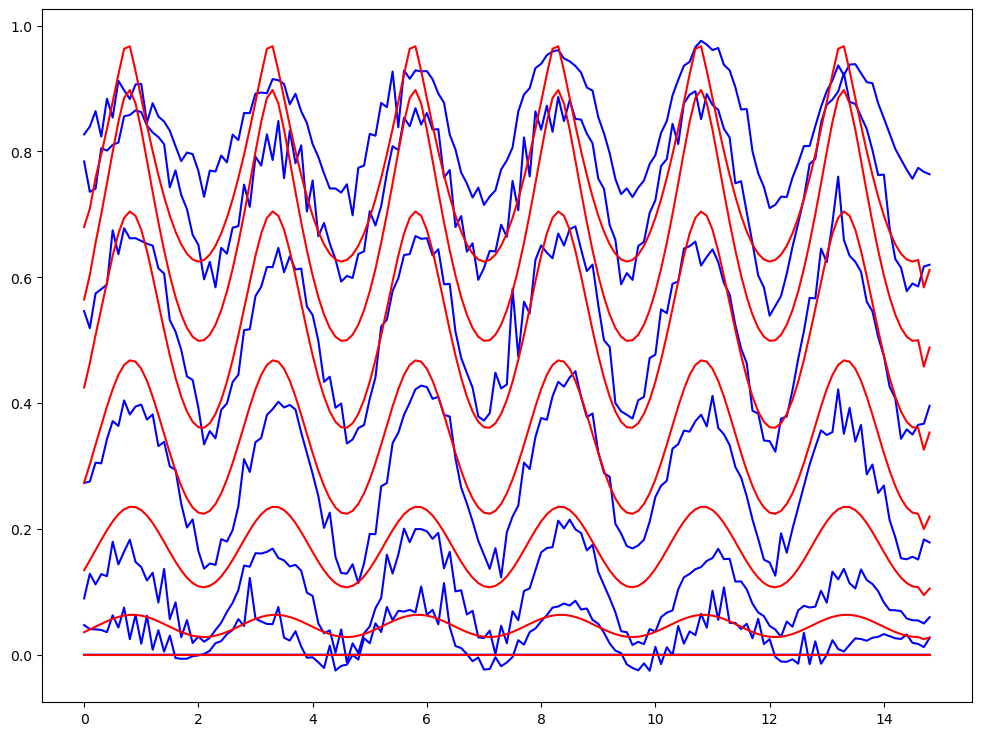

In [ ]:
plt.figure(figsize=(12, 9))
plot_sinuses(7, [[1.2, 0], [1.2, 0.6]])

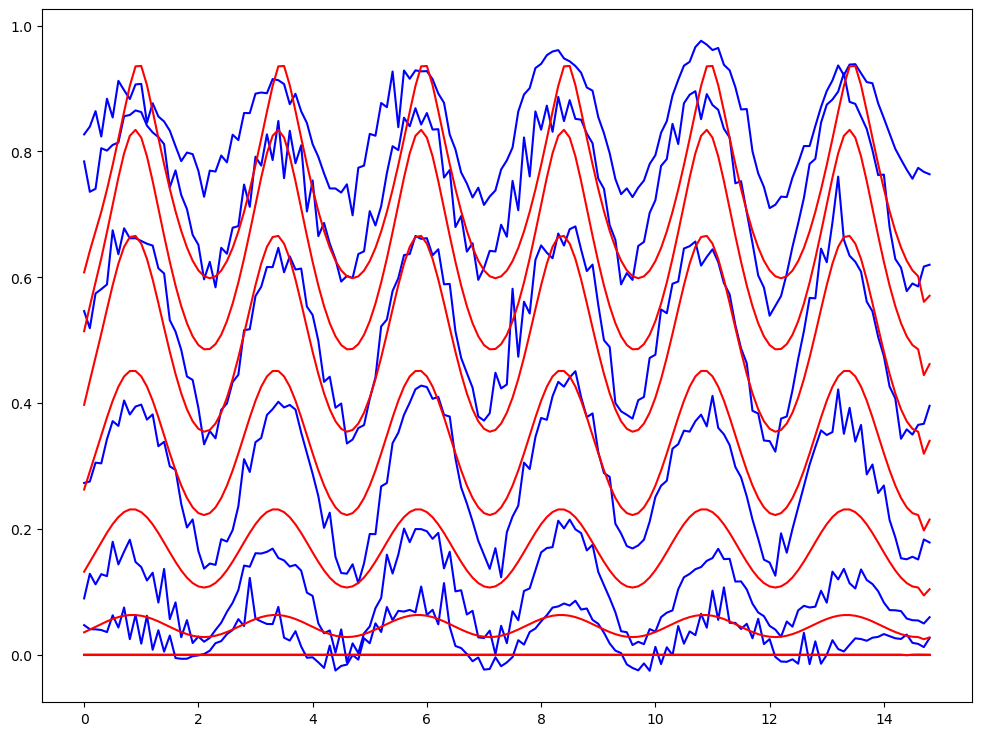

In [ ]:
plt.figure(figsize=(12, 9))
plot_sinuses(7, [[1.2, 1], [1.2, 1]])

In [ ]:
res_2 = least_squares(lambda C: compare_sinuses1(3, [1, C[0]]), [0.5], verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8576e+01                                    2.12e+04    
       1              2         1.8570e+01      5.92e-03       1.75e-03       2.39e+04    
       2              3         1.8569e+01      1.00e-03       4.38e-04       2.07e+04    
       3              4         1.8568e+01      4.42e-04       1.10e-04       3.89e+04    
       4              5         1.8568e+01      3.52e-04       2.74e-05       4.86e+04    
       5              7         1.8568e+01      2.41e-05       1.71e-06       1.22e+04    
       6             10         1.8568e+01      2.77e-04       2.67e-08       3.92e+04    
       7             13         1.8568e+01      0.00e+00       0.00e+00       3.92e+04    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 1.8576e+01, final cost 1.8568e+01, first-order optimality 3.92e+04.


In [ ]:
print(res_2.x)
print(res_2.message)
print(res_2.cost)

[0.5]
`xtol` termination condition is satisfied.
18.57505588894753


In [ ]:
config['env']['bimodal']['borning_modes'] = [1, 0]
config['env']['bimodal']['impact_modes'] = [1, 1]
config['env']['phys']['sigma'] = 0.9

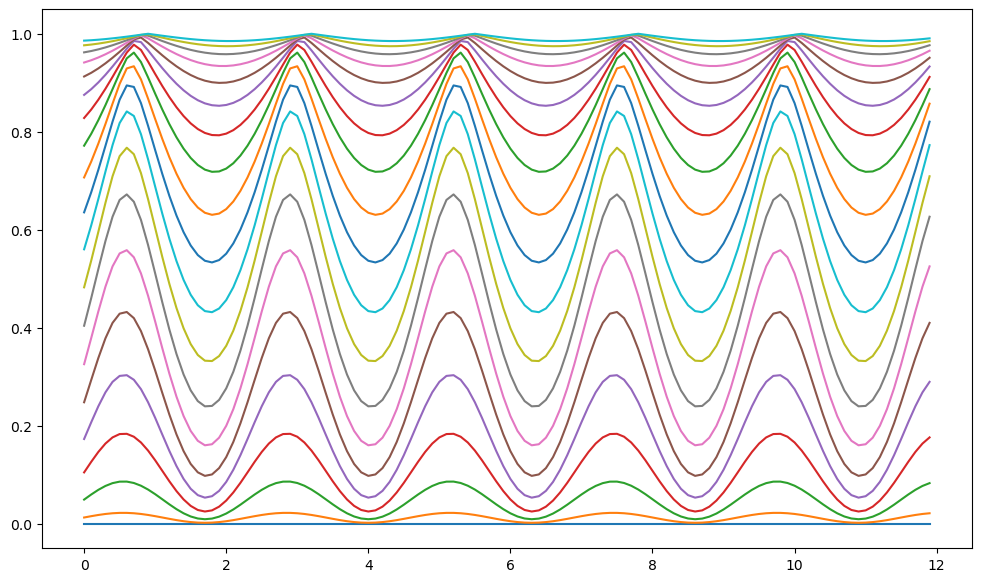

In [ ]:
config['env']['bimodal']['intermode_matrix'] = [[0.8, 0], [1.6, 1.6]]
simb = tbsl.FiberSimulator(config)

plt.figure(figsize=(12, 7))
for amplitude in np.linspace(0, 650, 20):
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    X = np.linspace(0, (len(sinus)-1)*0.1, len(sinus))
    plt.plot(X, sinus)
plt.savefig("max_shift.jpg")

# Эксперименты с оптимизатором

In [31]:
from scipy.optimize import least_squares
from scipy import optimize

In [11]:
def func(x):
    return x**2*(1+0.7*np.sin(x*10)+0.25*np.sin(x*15))

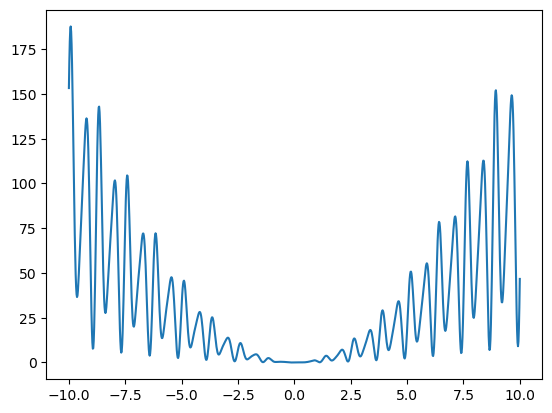

In [13]:
X = np.linspace(-10, 10, 1000)
Y = func(X)
plt.plot(X, Y)

 active_mask: array([0.])
        cost: 12.809016920891757
         fun: array([5.06142607])
        grad: array([-0.01008263])
         jac: array([[-0.00199205]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 18
        njev: 12
  optimality: 0.010082634522494978
      status: 2
     success: True
           x: array([7.40555633])
x
[7.40555633]
cost
12.809016920891757
fun
[5.06142607]
jac
[[-0.00199205]]
grad
[-0.01008263]
optimality
0.010082634522494978
active_mask
[0.]
nfev
18
njev
12
status
2
message
`ftol` termination condition is satisfied.
success
True


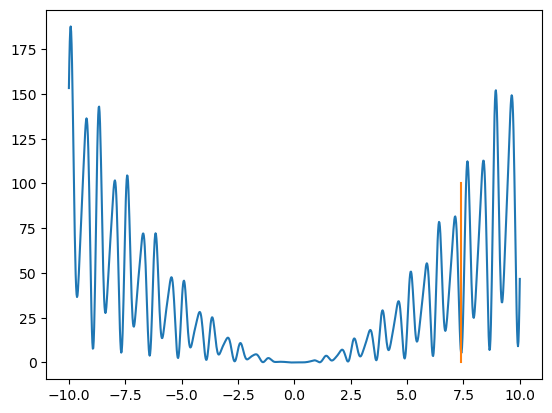

In [17]:
res = least_squares(func, 7.5)
print(res)

for key in res.keys():
    print(key)
    print(res[key])
    
plt.plot(X, Y)
plt.plot([res.x]*2, [0, 100])

 active_mask: array([0.])
        cost: 155.5595070768538
         fun: array([17.6385661])
        grad: array([-0.02972581])
         jac: array([[-0.00168527]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 18
        njev: 11
  optimality: 0.029725806713891894
      status: 2
     success: True
           x: array([6.69614086])
x
[6.69614086]
cost
155.5595070768538
fun
[17.6385661]
jac
[[-0.00168527]]
grad
[-0.02972581]
optimality
0.029725806713891894
active_mask
[0.]
nfev
18
njev
11
status
2
message
`ftol` termination condition is satisfied.
success
True


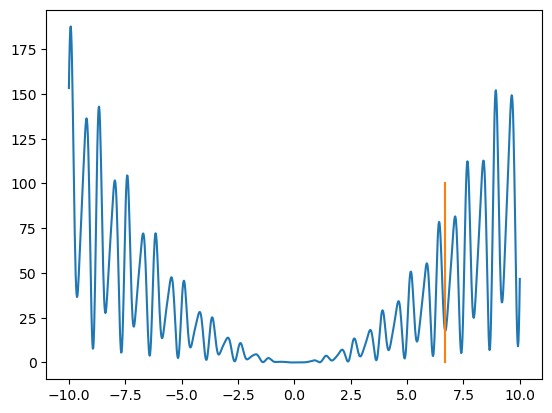

In [24]:
res = least_squares(func, 7)
print(res)

for key in res.keys():
    print(key)
    print(res[key])
    
plt.plot(X, Y)
plt.plot([res.x]*2, [0, 100])

 active_mask: array([0.])
        cost: 366.40459851171244
         fun: array([27.07044878])
        grad: array([-0.05029342])
         jac: array([[-0.00185787]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 18
        njev: 11
  optimality: 0.05029342184973832
      status: 2
     success: True
           x: array([5.35349542])
x
[5.35349542]
cost
366.40459851171244
fun
[27.07044878]
jac
[[-0.00185787]]
grad
[-0.05029342]
optimality
0.05029342184973832
active_mask
[0.]
nfev
18
njev
11
status
2
message
`ftol` termination condition is satisfied.
success
True


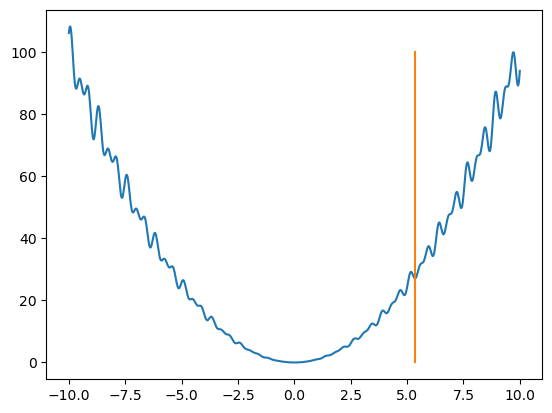

In [30]:
def func(x):
    return x**2*(1+0.05*np.sin(x*10)+0.05*np.sin(x*15))

res = least_squares(func, 7.5)
print(res)

for key in res.keys():
    print(key)
    print(res[key])
    
plt.plot(X, func(X))
plt.plot([res.x]*2, [0, 100])

     fun: 2.0471656806442214e-13
    funl: array([2.04716568e-13])
 message: 'Optimization terminated successfully.'
    nfev: 18
     nit: 2
   nlfev: 15
   nlhev: 0
   nljev: 7
 success: True
       x: array([-4.52456278e-07])
      xl: array([[-4.52456278e-07]])


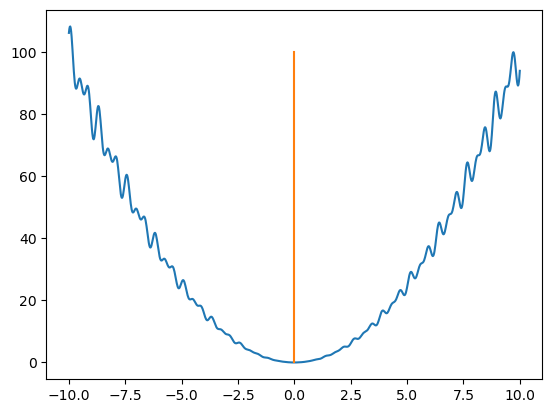

In [33]:

def func(x):
    return x**2*(1+0.05*np.sin(x*10)+0.05*np.sin(x*15))

res = optimize.shgo(func, [(-5, 8)])
print(res)

# for key in res.keys():
#     print(key)
#     print(res[key])
    
plt.plot(X, func(X))
plt.plot([res.x]*2, [0, 100])

     fun: 1.5501903708679265
    funl: array([1.55019037])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 2
   nlfev: 16
   nlhev: 0
   nljev: 6
 success: True
       x: array([1.65076163])
      xl: array([[1.65076163]])


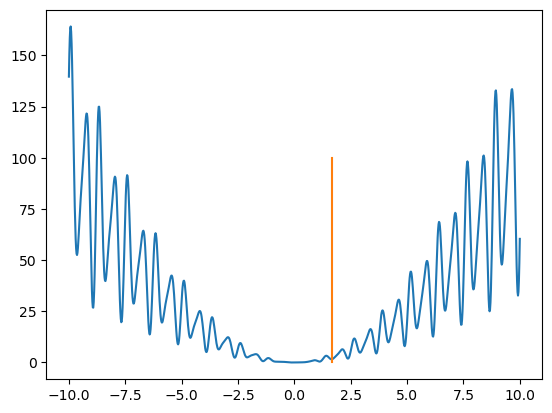

In [34]:

def func(x):
    return x**2*(1+0.5*np.sin(x*10)+0.2*np.sin(x*15))

res = optimize.shgo(func, [(-5, 8)])
print(res)

# for key in res.keys():
#     print(key)
#     print(res[key])
    
plt.plot(X, func(X))
plt.plot([res.x]*2, [0, 100])

Отлично. Эта штука выглядит, как то, что нужно.